In [1]:
import os
import json
from pathlib import Path
from decimal import Decimal

import numpy as np
import matplotlib.pyplot as plt
import py3dtiles.tileset.content
import pyproj
from PIL import Image, ImageColor
from transformers import SegformerForSemanticSegmentation
# import torch
from torchvision.transforms import transforms as T
# from torchvision.utils import save_image
import vtracer
import svgelements
import geopandas as gpd
# import shapely
from shapely.geometry import Polygon 

c:\Users\matve\.conda\envs\hack_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# изменить согласно собственным нуждам
config = {'b3dm_folder_path': Path('Цифровой прорыв/6. ДИТ/Hack-a-ton/FGM_HACKATON'), # путь до папки с b3dm тайлами
          'b3dm_load_level': 21, # уровень LOD-ов для обработки
          'gltf_folder_path': Path('gltf'), # путь до результата предобработки
          'paved_area_result_path': Path('paved_area_result.png'), # путь до результата сегментации (растр)
          'paved_area_vectorized_result_path': Path('paved_area_result.svg') # путь до результата сегментации (вектор)
          }

In [3]:
path_to_data = config['b3dm_folder_path']
path_to_result = config['gltf_folder_path']
path_to_rtc_centers = config['gltf_folder_path'] / Path('rtc_centers.json')

In [4]:
rtc_centers = {}

for root, d_names, f_names in os.walk(path_to_data):
    for f_name in f_names:
        if f_name.endswith('.b3dm') and 'L21' in f_name:
            # конвертировать в gltf
            b3dm = py3dtiles.tileset.content.read_binary_tile_content(Path(root) / Path(f_name))
            gltf = b3dm.body.gltf

            with (path_to_result / Path(f_name + '.gltf')).open('wb') as f:
                f.write(gltf.to_array())
            
            # сохранить центр тайла
            with open(Path(root) / Path(f_name), 'rb') as f:
                b3dm_line = f.read() 
            start = b3dm_line.find(b'{"BATCH_LENGTH"')
            end = b3dm_line.find(b'}\n')

            b3dm_data = b3dm_line[start:end+1].decode("utf-8")

            array_start = b3dm_data.find('[') + 1
            array_end = b3dm_data.find(']')
            xyz = b3dm_data[array_start:array_end]

            x_start = 0
            x_end = xyz.find(',')
            x = xyz[x_start:x_end]

            yz = xyz[x_end + 1:]
            y_start = 0
            y_end = yz.find(',')
            y = yz[y_start:y_end]

            z = yz[y_end + 1:]
            
            rtc_centers[f_name + '.gltf'] = [x, y, z]

if not os.path.isdir(path_to_result):
    os.mkdir(path_to_result)
with open(path_to_rtc_centers, 'w') as f:
    json.dump(rtc_centers, f)

mean_rtc_centers = np.array(list(rtc_centers.values())).astype(np.float64).mean(axis=0)

In [5]:
# конвертер из ECEF в WGS84
ecef_to_wgs84_transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    )

x, y, z = mean_rtc_centers[0], mean_rtc_centers[1], mean_rtc_centers[2] 
mean_lon, mean_lat, mean_alt = ecef_to_wgs84_transformer.transform(x,y,z, radians=False)
print (mean_lon, mean_lat, mean_alt)

37.59494030156928 55.76602868768972 182.14804515987635


In [6]:
# изменить согласно собственным нуждам
bledner_config = {
    'path_to_gltfs': str(config['gltf_folder_path']), # путь до предобработанных b3dm данных
    'path_to_rtc_centers': str(config['gltf_folder_path'] / Path('rtc_centers.json')), # путь до центров тайлов
    'path_to_render_result': str(Path('render.png').resolve()), # путь до результирующего рендера
    'path_to_corners': str(Path('corners.json')), # путь до координат углов рендера (вспомогательная информация)
    'surface_lat': str(mean_lat), # общая широта сцены
    'surface_lon': str(mean_lon), # общая долгота сцены
    'horizontal_resolution': 2000, # горизонтальное разрешение рендера
    'camera_z_margin': 100, # отступ камеры от меша по вертикали (менять нежелательно)
    'max_count': 300 # None, если необходимо отрендерить все тайлы (возможно потребуется много вычислительных мощностей)
}

with open('blender_config.json', 'w') as f:
    json.dump(bledner_config, f)

In [8]:
! blender --background --python tile_render.py -- blender_config.json

Blender 4.1.1 (hash e1743a0317bc built 2024-04-15 23:33:30)
Read prefs: "C:\Users\matve\AppData\Roaming\Blender Foundation\Blender\4.1\config\userpref.blend"
['blender_config.json']
Info: Deleted 4 data-block(s)
Data are loaded, start creating Blender stuff
17:25:47 | INFO: Draco Decoder: Decode primitive [unnamed]
DracoDecoder | Decoded 8661 vertices, 35463 indices
glTF import finished in 0.02s
Data are loaded, start creating Blender stuff
17:25:47 | INFO: Draco Decoder: Decode primitive [unnamed]
DracoDecoder | Decoded 13032 vertices, 51816 indices
glTF import finished in 0.02s
Data are loaded, start creating Blender stuff
17:25:47 | INFO: Draco Decoder: Decode primitive [unnamed]
DracoDecoder | Decoded 9429 vertices, 36756 indices
glTF import finished in 0.02s
Data are loaded, start creating Blender stuff
17:25:47 | INFO: Draco Decoder: Decode primitive [unnamed]
DracoDecoder | Decoded 7471 vertices, 29811 indices
glTF import finished in 0.01s
Data are loaded, start creating Blender

In [9]:
id2label = {0: 'unlabeled',1: 'paved-area',2: 'dirt',3: 'grass',4: 'gravel',5: 'water',6: 'rocks',7: 'pool',8: 'vegetation',9: 'roof',10: 'wall',11: 'window',12: 'door',13: 'fence',14: 'fence-pole',15: 'person',16: 'dog',17: 'car',18: 'bicycle',19: 'tree',20: 'bald-tree',21: 'ar-marker',22: 'obstacle',23: 'conflicting'}
label2id = {'unlabeled': 0,'paved-area': 1,'dirt': 2,'grass': 3,'gravel': 4,'water': 5,'rocks': 6,'pool': 7,'vegetation': 8,'roof': 9,'wall': 10,'window': 11,'door': 12,'fence': 13,'fence-pole': 14,'person': 15,'dog': 16,'car': 17,'bicycle': 18,'tree': 19,'bald-tree': 20,'ar-marker': 21,'obstacle': 22,'conflicting': 23}

In [11]:
paved_area_road_model = SegformerForSemanticSegmentation.from_pretrained("checkpoint-500",
                                                        id2label = id2label,
                                                        label2id = label2id,)

paved_area = 1
road = 9 # почему-то крыша

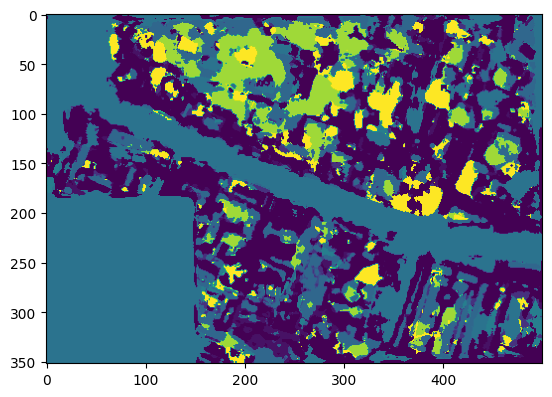

In [12]:
image = Image.open(Path(bledner_config['path_to_render_result'])).convert('RGB')
w, h = image.size
# image = image.crop((3000, 1500, w-500, h-700))
# image = image.crop((1000, 1000, 2000, 2000))

train_transforms = T.Compose([
    T.ToTensor(),
])

# Transform Image
image_t = train_transforms(image)
output = paved_area_road_model(image_t.unsqueeze(0))

output1 = output.logits.squeeze().argmax(0)
plt.imshow(output1)
image.show()

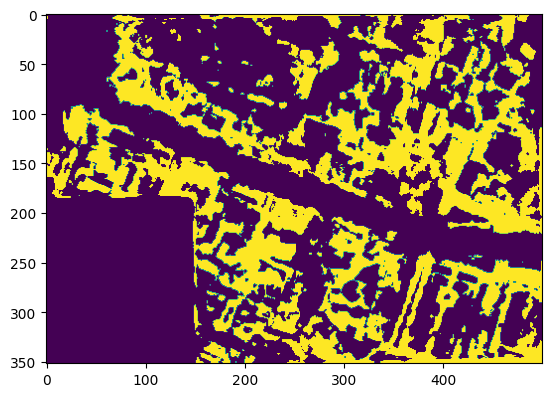

In [13]:
output2 = output1.clone()
output2[output2 != 1] = 0
output2[output2 != 0] = 255
plt.imshow(output2)

out_image = Image.fromarray(output2.numpy().astype(np.uint8))
out_image.save(config['paved_area_result_path'])

In [14]:
vtracer.convert_image_to_svg_py(str(config['paved_area_result_path']), str(config['paved_area_vectorized_result_path']),
                                colormode = 'color',        # ["color"] or "binary"
                                hierarchical = 'cutout',   # ["stacked"] or "cutout"
                                mode = 'polygon',            # ["spline"] "polygon", or "none"
                                filter_speckle = 4,         # default: 4
                                color_precision = 8,        # default: 6
                                layer_difference = 0,      # default: 16
                                max_iterations = 10,        # default: 10
                                path_precision = 8          # default: 8
                               )

In [15]:
with open(bledner_config['path_to_corners'], 'r') as f:
    corners = json.load(f)

top_left = [Decimal(coord) for coord in corners['top_left']]
top_right = [Decimal(coord) for coord in corners['top_right']]
bottom_left = [Decimal(coord) for coord in corners['bottom_left']]
bottom_right = [Decimal(coord) for coord in corners['bottom_right']]

# bottom_right = [Decimal(coord) for coord in corners['bottom_left']]
# bottom_left = [Decimal(coord) for coord in corners['bottom_right']]

points = [(Decimal(0), Decimal(0), np.array(top_left)), (Decimal(out_image.width), Decimal(0), np.array(top_right)), (Decimal(0), Decimal(out_image.height), np.array(bottom_left)), (Decimal(out_image.width), Decimal(out_image.height), np.array(bottom_right))]
# points = [(Decimal(0), Decimal(0), np.array([])), (Decimal(out_image.width), Decimal(0), np.array(top_right)), (Decimal(0), Decimal(out_image.height), np.array(bottom_left)), (Decimal(out_image.width), Decimal(out_image.height), np.array(bottom_right))]

# https://stackoverflow.com/questions/8661537/how-to-perform-bilinear-interpolation-in-python
def bilinear_interpolation(x, y, points = points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + Decimal(0.0))

<Axes: >

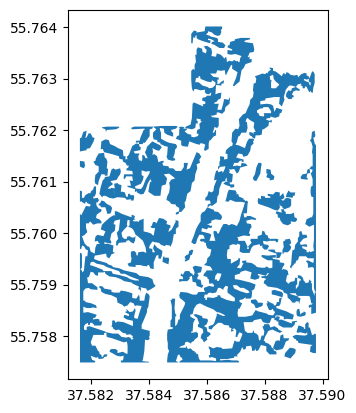

In [16]:
svg = svgelements.SVG.parse(str(config['paved_area_vectorized_result_path']))

polygons = []
for element in svg.elements():
    for path in element:
        if type(path) is svgelements.Path:
            
            is_paved_area = ImageColor.getcolor(str(path.fill), "RGB")[0] > 255 / 2
            
            lat_list_fill = []
            lon_list_fill = []

            list_hole = []
            list_holes = []

            if is_paved_area:
                move_cnt = 0
                for primitive in path:
                    if type(primitive) is svgelements.Move:
                        move_cnt += 1
                        if len(list_hole) >= 3:
                            list_holes.append(list_hole)

                        list_hole = []
                    
                    if type(primitive) is svgelements.Line or type(primitive) is svgelements.Close:
                        x, y, z = bilinear_interpolation(Decimal(primitive.start[0]), Decimal(primitive.start[1]))
                        lat, lon, alt = ecef_to_wgs84_transformer.transform(x,y,z, radians=False)
                        
                        if move_cnt <= 1:
                            lat_list_fill.append(lat)
                            lon_list_fill.append(lon)
                        else:
                            list_hole.append((lat, lon))

                        x, y, z = bilinear_interpolation(Decimal(primitive.end[0]), Decimal(primitive.end[1]))
                        lat, lon, alt = ecef_to_wgs84_transformer.transform(x,y,z, radians=False)
                        if move_cnt <= 1:
                            lat_list_fill.append(lat)
                            lon_list_fill.append(lon)
                        else:
                            list_hole.append((lat, lon))

                polygon = Polygon(zip(lat_list_fill, lon_list_fill), list_holes)
                polygons.append(polygon)

polygons_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry=polygons) 
polygons_gdf.plot()

In [17]:
polygons_gdf.to_file("output.geojson", driver="GeoJSON")